In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Preliminaries

In [4]:
# Reading in example response times (RT) data
df = pd.read_csv('../data/rt_example_data.csv', delimiter=';')

In [5]:
# Explore the top five rows
df.head()

,#TIME,TRIAL,RESPONSE,RT,PRIME,TARGET,TYPE,RESULT,QUESTION
0,82.2292,1,0,0.4851,0,1,incongruent,incorrect,0
1,85.9700,2,0,0.5515,1,0,incongruent,correct,0
2,89.2500,3,1,0.6348,1,0,congruent,incorrect,0
3,92.6600,4,0,0.7683,0,0,congruent,correct,0
4,96.5800,5,1,0.5181,1,1,incongruent,correct,0


Text(0, 0.5, 'Frequency')

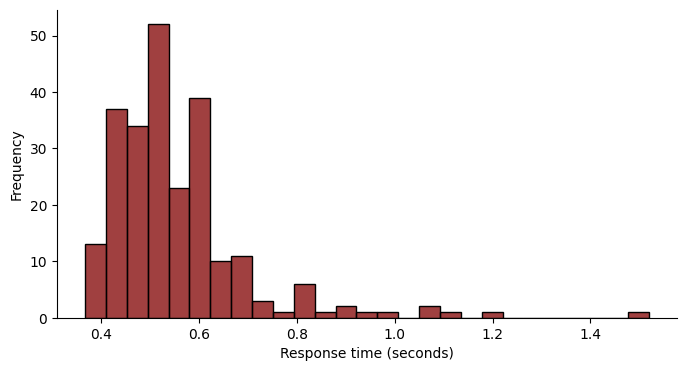

In [48]:
# Simple way to create a nice histogram of all RTs
rts = df.RT.values
f, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(rts[rts<=3.0], color='maroon', ax=ax)
sns.despine(ax=ax)
ax.set_xlabel('Response time (seconds)')
ax.set_ylabel('Frequency')

## Coding Random Walks

In [26]:
def simulate_discrete_rw(T=1000):
    """Simulates a simple discrete random walk given a time horizon T."""

    x = np.zeros(shape=T)
    for t in range(1, T):
        w = np.random.randint(low=0, high=2)
        w = -1 if w == 0 else 1
        x[t] = x[t-1] + w
    return x

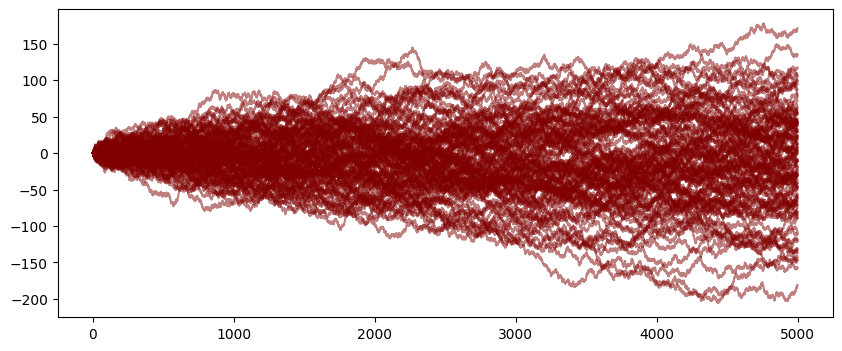

In [29]:
# Visualize a few random walkers
num_walks = 100
f, ax = plt.subplots(1, 1, figsize=(10, 4))

for _ in range(num_walks):
    x = simulate_discrete_rw(T=5000)
    ax.plot(x, color='maroon', alpha=0.5)

In [40]:
def simulate_random_walk(T=100, sigma=1.0):
    """Simulates one realization of a discrete random walk process.
    
    Parameters:
    -----------
    T     : int, optional (default: 100)
        The time horizon of the process
    sigma : float, optional (default: 1.0)
        The scale (sqrt(variance)) of the random steps.

    Returns:
    --------
    x : np.ndarray of shape (T, )
        An array containing the simulated random walk trajectory.
    """

    x = np.zeros(T)
    for t in range(1, T):
        x[t] = x[t-1] + np.random.normal(loc=0., scale=sigma)
    return x


def simulate_random_walk_noloop(T=100, sigma=1.0):
    """Simulates one realization of a discrete random walk process.
    
    Parameters:
    -----------
    T     : int, optional (default: 100)
        The time horizon of the process
    sigma : float, optional (default: 1.0)
        The scale (sqrt(variance)) of the random steps.

    Returns:
    --------
    x : np.ndarray of shape (T, )
        An array containing the simulated random walk trajectory.
    """

    return np.cumsum(np.random.normal(loc=0., scale=sigma, size=T))

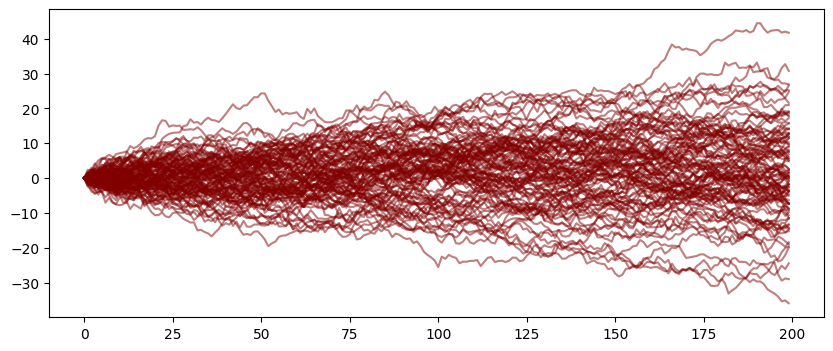

In [38]:
# Visualize 'num_walks' realizations of the inefficiently implemented process
num_walks = 100
f, ax = plt.subplots(1, 1, figsize=(10, 4))

for _ in range(num_walks):
    x = simulate_random_walk(T=200) 
    ax.plot(x, color='maroon', alpha=0.5)

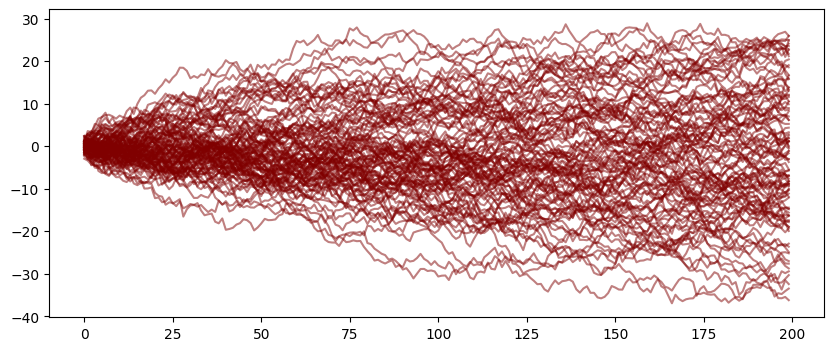

In [41]:
# Visualize 'num_walks' realizations of the efficiently implemented process
num_walks = 100
f, ax = plt.subplots(1, 1, figsize=(10, 4))

for _ in range(num_walks):
    x = simulate_random_walk_noloop(T=200)
    ax.plot(x, color='maroon', alpha=0.5)

In [ ]:
# TODO
# 1. Clean implementation of the visualization function
# 2. Fully vectorized random walk function (i.e., generate multiple realizations at once)

In [11]:
def simulate_random_walk_multiple(N=10, T=500, scale=1.):
    """Nice docstring..."""

    # Draw random Gaussian variates
    z = np.random.normal(loc=0., scale=scale, size=(N, T))

    # Apply cumulative sum over time axis
    r = np.cumsum(z, axis=1)

    # Return result
    return r


def visualize_random_walks(trajectories):
    """Produces a simple plot of multiple random walk trajectories.
    
    Parameters:
    -----------
    
    trajectories : np.ndarray of shape (N, T)
        The `T` Random Walk realizations.

    Returns:
    --------
    f : plt.Figure
        The figure instance (for saving etc...)
    """

    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(trajectories.T, color='maroon', alpha=0.7)
    sns.despine(ax=ax)
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Process value')
    return f


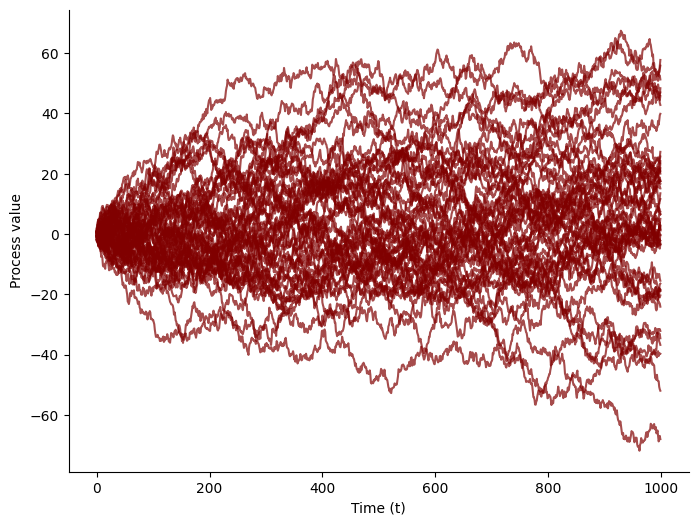

In [12]:
trajectories = simulate_random_walk_multiple(50, 1000)
f = visualize_random_walks(trajectories)

## Coding up the diffusion model

In [47]:
from numba import njit

In [54]:
@njit
def simulate_diffusion(v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v     : float
        The drift rate (rate of information uptake)
    a     : float
        The boundary separation (decision threshold).
    beta  : float in [0, 1]
        Relative starting point (prior option preferences)
    tau   : float
        Non-decision time (additive constant)
    dt    : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time: float, optional (default: .10)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """

    # Inits (process starts at relative starting point)
    y = beta * a
    num_steps = tau
    const = scale*np.sqrt(dt)

    # Loop through process and check boundary conditions
    while (y <= a and y >= 0) and num_steps <= max_time:

        # Perform diffusion equation
        z = np.random.randn()
        y += v*dt + const*z

        # Increment step counter
        num_steps += dt

    if y >= a:
        c = 1.
    else:
        c = 0.
    return (round(num_steps, 3), c)

@njit
def simulate_diffusion_n(num_sims, v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.):
    """Add a nice docstring."""

    data = np.zeros((num_sims, 2))
    for n in range(num_sims):
        data[n, :] = simulate_diffusion(v, a, beta, tau, dt, scale, max_time)
    return data


def visualize_diffusion_model(data, figsize=(8, 6)):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    sns.histplot(data[:, 0][data[:, 1] == 1], color='maroon', alpha=0.7, ax=ax, label='Correct responses')
    sns.histplot(data[:, 0][data[:, 1] == 0], color='gray', ax=ax, label='Incorrect responses')
    sns.despine(ax=ax)
    ax.set_xlabel('Response time (s)', fontsize=18)
    ax.set_ylabel('')
    ax.legend(fontsize=18)
    ax.set_yticks([])
    return f


In [55]:
params = {
    'v': 1,
    'a': 3,
    'beta': 0.5,
    'tau': 0.7
}

In [58]:
%%time
data = simulate_diffusion_n(1000, **params)

CPU times: user 20.6 ms, sys: 8.75 ms, total: 29.3 ms
Wall time: 31.6 ms


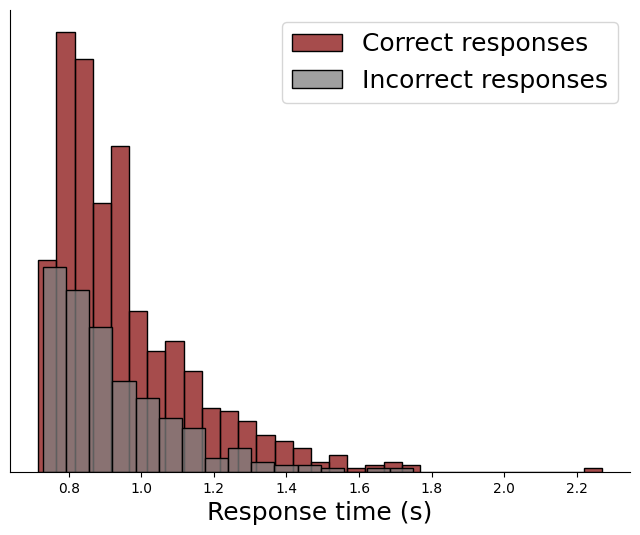

In [43]:
f = visualize_diffusion_model(data)
f.savefig('test_diffusion_output.png', dpi=300)

In [35]:
def simulate_lca(v, x0, a, beta, kappa, tau, dt=1e-3, scale=1.0, max_time=10.):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v     : np.ndarray
        The drift rates (rates of information uptake)
    x0    : np.ndarray
        The starting points
    a     : float
        The boundary separation (decision threshold).
    beta  : float in [0, inf+)
        Inhibition parameter
    kappa : float in [0, 1]
        Leakage parameter
    tau   : float [0 , inf+)
        Non-decision time (additive constant)
    dt    : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time: float, optional (default: 10.)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """

    # Inits (process starts at relative starting point)
    num_steps = tau
    const = scale*np.sqrt(dt)
    x = x0.copy()
    assert x.shape[0] == v.shape[0]
    J = x0.shape[0]

    # Loop through process and check boundary conditions
    while num_steps <= max_time:
        
        # Sample random noise variate
        z = np.random.randn(J)

        # Loop through accumulators
        for j in range(J):
            # LCA equation
            dx_j = (v[j] - beta*(sum(x) - x[j]) - kappa*x[j])*dt + const*z[j]
            x[j] = max(x[j] + dx_j, 0)

        # Increment step counter
        num_steps += dt

        # Check for boundary hitting
        if any(x >= a):
            break
    
    return (round(num_steps, 3), x.argmax())

def simulate_lca_n(num_sims, **kwargs):
    data = np.zeros((num_sims, 2))
    for n in range(num_sims):
        data[n, :] = simulate_lca(**kwargs)
    return data

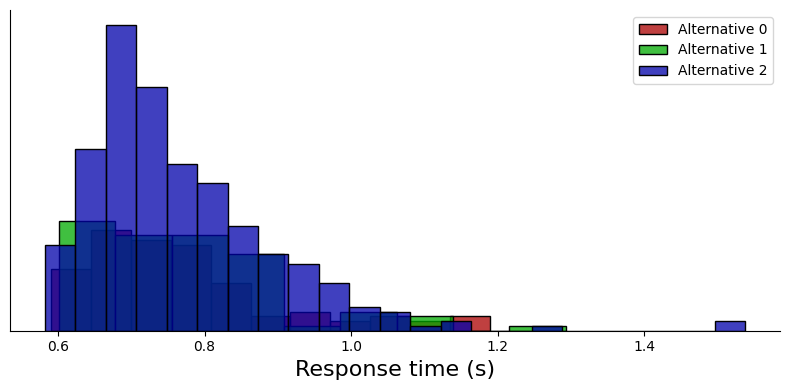

In [36]:
# Simulation parameters
parameters = {
    'v': np.array([1., 1., 3.]),
    'x0': np.zeros(3),
    'a': 1.,
    'tau': 0.5,
    'beta': 0.6,
    'kappa': 0.2
}

# Simulator (for n_obs)
sim_data = simulate_lca_n(500, **parameters)


# Visualize empirical RT distribution
f, ax = plt.subplots(1, 1, figsize=(8, 4))
colors = ['#AA0000', '#00AA00', '#0000AA']
for j in range(parameters['v'].shape[0]):
    sns.histplot(sim_data[:, 0][sim_data[:, 1] == j], color=colors[j], label=f'Alternative {j}')
ax.legend()
sns.despine(ax=ax)
ax.set_xlabel('Response time (s)', fontsize=16)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_yticks([])
f.tight_layout()

In [32]:
sim_data

array([[1.315, 2.   ],
       [1.398, 2.   ],
       [1.292, 0.   ],
       [1.267, 2.   ],
       [2.225, 2.   ],
       [0.754, 2.   ],
       [1.445, 1.   ],
       [2.119, 2.   ],
       [0.93 , 2.   ],
       [1.353, 2.   ],
       [1.855, 2.   ],
       [1.179, 2.   ],
       [1.904, 2.   ],
       [1.298, 2.   ],
       [0.952, 2.   ],
       [1.077, 0.   ],
       [1.049, 2.   ],
       [1.637, 2.   ],
       [1.202, 2.   ],
       [0.863, 2.   ],
       [1.303, 1.   ],
       [1.919, 2.   ],
       [1.867, 2.   ],
       [1.644, 1.   ],
       [0.88 , 2.   ],
       [1.011, 2.   ],
       [0.907, 2.   ],
       [1.33 , 2.   ],
       [1.11 , 0.   ],
       [1.194, 2.   ],
       [1.503, 2.   ],
       [0.959, 1.   ],
       [0.744, 2.   ],
       [1.062, 2.   ],
       [0.936, 2.   ],
       [1.51 , 2.   ],
       [0.926, 1.   ],
       [1.323, 2.   ],
       [1.623, 2.   ],
       [1.304, 2.   ],
       [1.072, 2.   ],
       [1.015, 2.   ],
       [0.893, 2.   ],
       [1.6